In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import seaborn as sns
import matplotlib.pylab as plt

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
class GruCell(nn.Module):
    def __init__(self, hidden_size = 10):
        super(GruCell, self).__init__()
        self.my_reset = nn.Linear(hidden_size, hidden_size)
        self.my_update = nn.Linear(hidden_size, hidden_size)
        self.my_final = nn.Linear(hidden_size, hidden_size)
        self.neighbours_reset = nn.Linear(4 * hidden_size, hidden_size)
        self.neighbours_update = nn.Linear(4 * hidden_size, hidden_size)
        self.neighbours_final = nn.Linear(4 * hidden_size, hidden_size)

    def forward(self, state, x):
        reset_chooser = torch.sigmoid(self.my_reset(state) + self.neighbours_reset(x))
        resetted = reset_chooser * state
        update_chooser = torch.sigmoid(self.my_update(state) + self.neighbours_update(x))
        update = torch.tanh(self.my_final(resetted) + self.neighbours_final(x))
        update = update_chooser * update
        new_state = (1 - update_chooser) * state + update
        return reset_chooser, update_chooser, update, new_state

In [52]:
def autism_loss(reset, update, delta, state):
    return - torch.mean(reset ** 2) - torch.mean(update ** 2)  - torch.mean(state ** 2) + torch.mean(delta ** 2)

def prefer_biggest_loss(reset, update, delta, state):
    priority = torch.mean(state ** 2, axis = 1)
    priority = priority.reshape(delta.shape[0], 1)
    return - torch.mean(priority * reset ** 2) - torch.mean(priority * update ** 2)  + torch.mean(priority * delta ** 2)

In [53]:
field_size = 102
hidden_size = 8
epochs = 100
batch_size = 32

In [54]:
net = GruCell(hidden_size).to(device)
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [55]:
field = torch.randn(field_size, field_size, hidden_size)
# зануляем края
for i in range(field_size):
    for j in range(field_size):
        if i == 0 or j == 0 or i == field_size - 1 or j == field_size - 1:
            field[i, j] = torch.zeros(hidden_size)

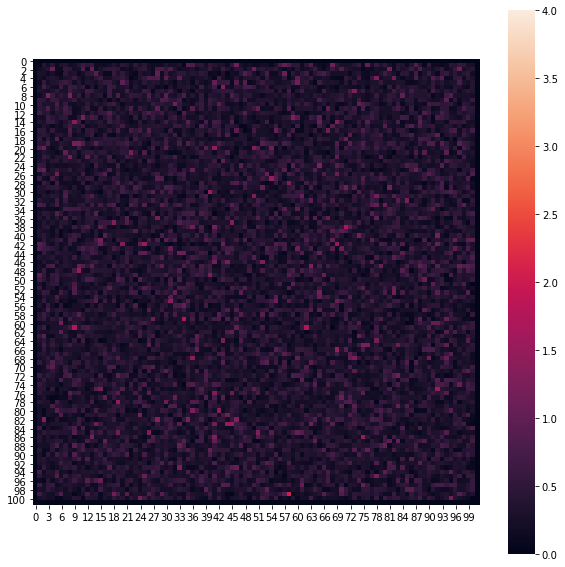

[1] loss: -0.175; Mean Information : 0.35475054383277893


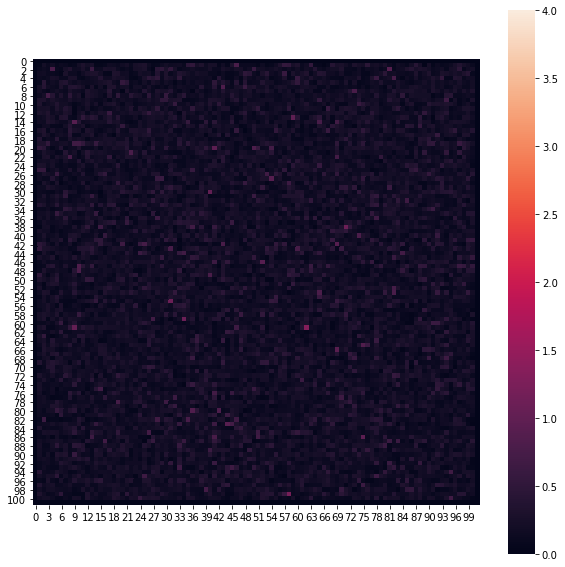

[2] loss: -0.100; Mean Information : 0.1964206099510193


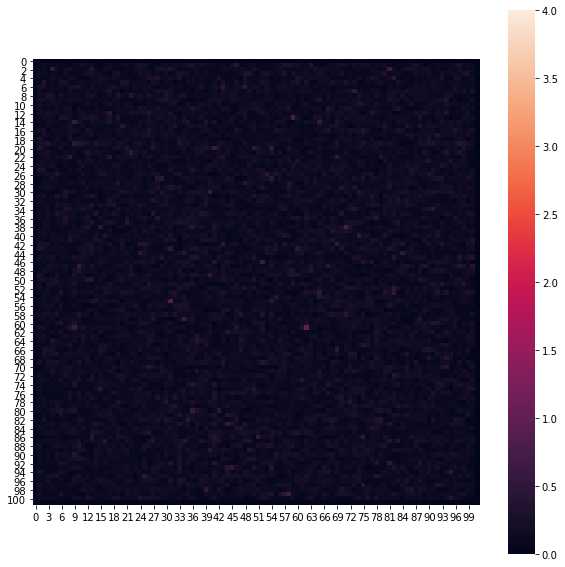

[3] loss: -0.074; Mean Information : 0.1419786959886551


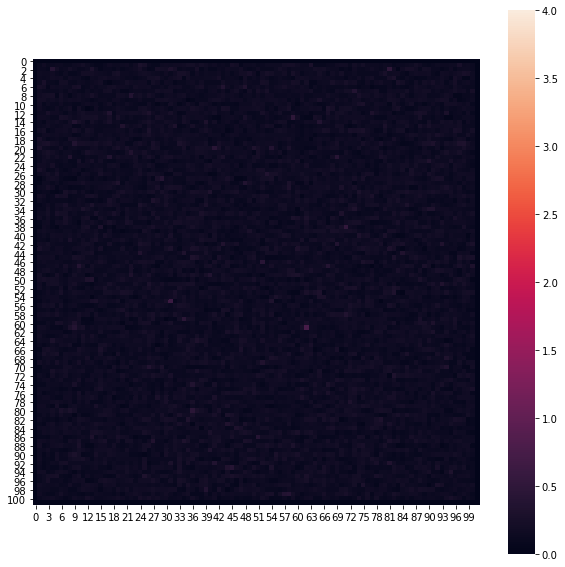

[4] loss: -0.076; Mean Information : 0.14097964763641357


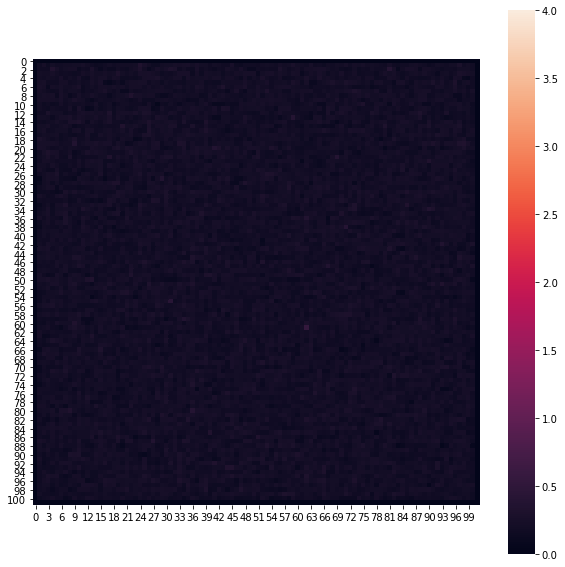

[5] loss: -0.107; Mean Information : 0.1893824338912964


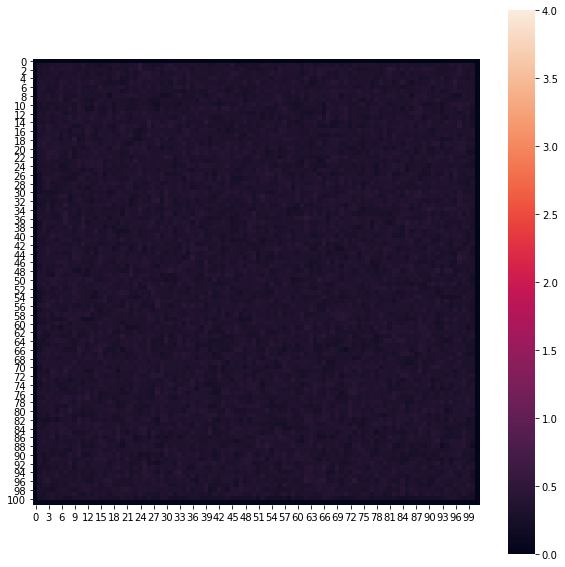

[6] loss: -0.192; Mean Information : 0.3148842453956604


In [ ]:

pump_energy = False
use_prefer_bigger_loss = True
for e in range(epochs):
    new_field = torch.zeros(field_size, field_size, hidden_size)
    train_set = []
    for i in range(1, field_size - 1):
        for j in range(1, field_size - 1):
            tmp = []
            tmp.append(field[i, j].to(device))
            # верхние и боковые соседи
            tmp.append(torch.cat([field[i - 1, j], field[i + 1, j], field[i, j - 1], field[i, j + 1]]).to(device))
            # координаты поля
            tmp.append((i, j))
            train_set.append(tmp)
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0)
    running_loss = 0.0
    for cells, neighbours, cords in train_loader:
        loc_y, loc_x = cords
        optimizer.zero_grad()
        reset, update, delta, state = net(cells, neighbours)
        if use_prefer_bigger_loss:
            loss = prefer_biggest_loss(reset, update, delta, state)
        else:
            loss = autism_loss(reset, update, delta, state)
        loss.backward()
        optimizer.step()
        for new_state, y, x in zip(state, loc_y, loc_x):
            new_field[y, x] = new_state
        # print statistics
        running_loss += loss.item()
    mean_information = torch.mean(field ** 2)
    with torch.no_grad():
        field = new_field.clone()
        fig, ax = plt.subplots(figsize=(10,10))   
        ax = sns.heatmap(torch.mean(field ** 2, axis = 2), ax=ax, square=True,  vmin = 0, vmax = 4)
        plt.show()
        if pump_energy:
            # эксмерементирую с константой, сколько нового рандома вносить
            field += torch.randn(field_size, field_size, hidden_size) * 0.3
    print(f'[{e + 1}] loss: {running_loss /  len(train_loader):.3f}; Mean Information : {torch.mean(field ** 2)}')

In [ ]:
torch.save(net.state_dict(), 'models/first_model')